In [1]:
#Import packages
%matplotlib inline
import numpy as np
np.seterr(all='ignore')
import sympy
sympy.init_printing()
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["axes.unicode_minus"] = False
#import scipy.sparse as sp
#import scipy.sparse.linalg
import numba as nb

In [2]:
#Setting parameters
c=3*10**11                                                #(mm/s)
l=1                                                       #(mm)
timeunit=10**(-9)                                         #(10^(-9)s/ns)
ls=c*timeunit                                             #(mm/ns)
HalfLifeTime=98.3*10**(-9)                                #(s)
Gamma=np.log(2)*timeunit/HalfLifeTime                     #(1/ns)
xi=10#7.96*5                                              #nuclear resonance thickness
ZeemanD=50                                                #unit of Gamma
#eta=xi*Gamma/(2*l)                                        #(1/(ns*mm))
delta_1=ZeemanD*0.15532/(0.15532 + 0.090604)*Gamma
delta_2=ZeemanD*0.090604/(0.15532 + 0.090604)*Gamma
C_31=C_42=(2/3)**0.5                                      #CG coefficients
midp=50                                                   #(ns)
widp=5                                                    #(ns)
tDomain=100                                               #(total time:ns)
k=0                                                       #scale factor
M=5                                                       #number of targets
rate=500
velo=4.834*10**(-9)                                       #(mm/ns)
rmidt=60                                                  #(ns)
k_number=11
xi_number=6

In [3]:
#Discretize time and space
#dz=0.04*l
#n_P=int(l/dz+1)
#dt=0.00002*widp
#n_T=int(tDomain/dt+1) 
#z=np.linspace(0, l, n_P)
#t=np.linspace(0, tDomain, n_T)
n_P=51   #51 
dz=l/(n_P-1)
n_T=1500001   #10001   
dt=tDomain/(n_T-1)

z=np.arange(0, l+dz, dz)
t=np.arange(0, tDomain+dt, dt)

#dimensionless t and z
dz_bar=dz/l
z_bar=z/l
dt_bar=dt/(l/ls)
t_bar=t/(l/ls)

#Create 2-D arrays for rho_31, rho_42 and OmegaP (rows: time; columns: space)
rho_31=np.zeros((n_T, n_P), dtype=complex)
rho_42=np.zeros((n_T, n_P), dtype=complex)
OmegaP=np.zeros((n_T, n_P), dtype=complex)

#Initial and boundary conditions
rho_31[0, :]=0
rho_42[0, :]=0
OmegaP[0, :]=0
OmegaP[:, 0]=np.exp(-((t-midp)/widp)**2)

#Define the detuning in each discrete space
def heaviside(Z):
    return 1.0*(Z > 0)

Cutpoint=np.zeros(M-1)
Bstep=np.zeros((M-1, n_P))
delta_g=np.zeros((k_number, n_P))
delta_e=np.zeros((k_number, n_P))
for ki in range (0, k_number):
    a_n_tot=0
    for j in range(0, M):
        a_n_tot+=np.exp(-((k*widp*(j-(M-1)/2)*(delta_1 + delta_2))/2)**2)

    for n in range(1, M):
        a_n=0
        for j in range(0, n):
            a_n+=np.exp(-((k*widp*(j-(M-1)/2)*(delta_1 + delta_2))/2)**2)/a_n_tot
        Cutpoint[n-1]=a_n*l

    for i in range(0, M-1):
        Bstep[i,:]=heaviside(z-Cutpoint[i])    
    
    delta_gk=(np.sum(Bstep, axis=0)-(M-1)/2)*delta_1
    delta_ek=(np.sum(Bstep, axis=0)-(M-1)/2)*delta_2
    
    delta_g[ki, :]=delta_gk
    delta_e[ki, :]=delta_ek
    k+=1/(k_number-1)
    
@nb.jit(nopython=True)
def PDE_jit(rho_31, rho_42, OmegaP):
    efficiency=np.zeros((xi_number, k_number))
    for xii in range (0, xi_number):
        eta=(xi+5*xii)*Gamma/(2*l) 
        for ki in range (0, k_number):
            delta_G=delta_g[ki, :]
            delta_E=delta_g[ki, :]
            idx=0
            #Solving PDE by finite difference method
            for s in range(1, n_T):
                #Define 1-D spatial forward difference in each row 
                deltaOmegaP_z=(OmegaP[idx, 1:]-OmegaP[idx, 0:-1])/dz
    
                rho_31c=rho_31[idx, 1:]
                rho_42c=rho_42[idx, 1:]
                OmegaPc=OmegaP[idx, 1:]
            
                rho_31[idx+1, 1:]=rho_31c+dt*(-Gamma/2*rho_31c-np.complex(0,1)/2*(2*(delta_G[1:]+delta_E[1:])*rho_31c-C_31/2*OmegaPc))
                rho_42[idx+1, 1:]=rho_42c+dt*(-Gamma/2*rho_42c+np.complex(0,1)/2*(2*(delta_G[1:]+delta_E[1:])*rho_42c+C_42/2*OmegaPc))
                OmegaP[idx+1, 1:]=OmegaPc+dt*(np.complex(0,1)*ls*(8*eta/(0.5*(C_31**2+C_42**2)))*(C_31*rho_31c+C_42*rho_42c)-ls*deltaOmegaP_z)
                idx=idx+1
           
            efficiency[xii, ki]=(np.sum(np.abs(OmegaP[int(60/dt+1):int(80/dt+1),-1])**2*dt))/(np.sum(np.abs(OmegaP[int(40/dt+1):int(60/dt+1),0])**2*dt))
    
    return efficiency #rho_31, rho_42, OmegaP

In [4]:
%time 
efficiency=PDE_jit(rho_31, rho_42, OmegaP)

Wall time: 0 ns


In [5]:
print(efficiency)

[[ 0.13017555  0.14521988  0.14521988  0.1492096   0.17884433  0.20668402
   0.21108621  0.24117367  0.27875484  0.29482294  0.3019412 ]
 [ 0.2182783   0.23806413  0.23806413  0.24361139  0.27888887  0.30703725
   0.31306524  0.34027358  0.35621927  0.35829111  0.34757429]
 [ 0.29059668  0.31007237  0.31007237  0.31619897  0.34642655  0.36449997
   0.37122803  0.38584947  0.37147412  0.35968404  0.33566303]
 [ 0.34246462  0.35792453  0.35792453  0.36398513  0.38295708  0.38723973
   0.3941423   0.3951379   0.35909536  0.34131374  0.3142568 ]
 [ 0.37533792  0.38491704  0.38491704  0.3906469   0.39671751  0.38862762
   0.39550575  0.38687947  0.3428428   0.32640658  0.30352652]
 [ 0.39306513  0.39645908  0.39645908  0.40185977  0.39652879  0.38003129
   0.38684234  0.37388171  0.33247913  0.320691    0.30386384]]


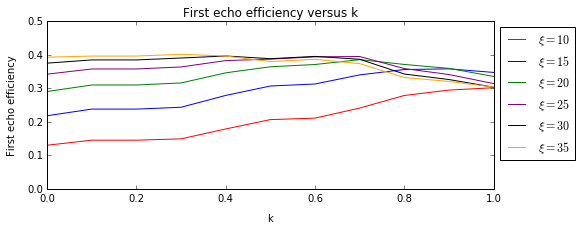

In [6]:
kvalues=np.linspace(0, 1, 11)
fig, axe = plt.subplots(1, 1, figsize=(8, 3))
axe.plot(kvalues, efficiency[0, :], color='r', label=r"$\xi=10$", lw=1)
axe.plot(kvalues, efficiency[1, :], color='b', label=r"$\xi=15$", lw=1)
axe.plot(kvalues, efficiency[2, :], color='g', label=r"$\xi=20$", lw=1)
axe.plot(kvalues, efficiency[3, :], color='purple', label=r"$\xi=25$", lw=1)
axe.plot(kvalues, efficiency[4, :], color='black', label=r"$\xi=30$", lw=1)
axe.plot(kvalues, efficiency[5, :], color='orange', label=r"$\xi=35$", lw=1)
axe.set_ylim(0, 0.5)
axe.set_xlabel("k", fontsize=10, labelpad=10)
axe.set_ylabel("First echo efficiency", fontsize=10, labelpad=10)
axe.set_title("First echo efficiency versus k", fontsize=12)
axe.legend(fontsize=12, loc=2, bbox_to_anchor=(1, 1))

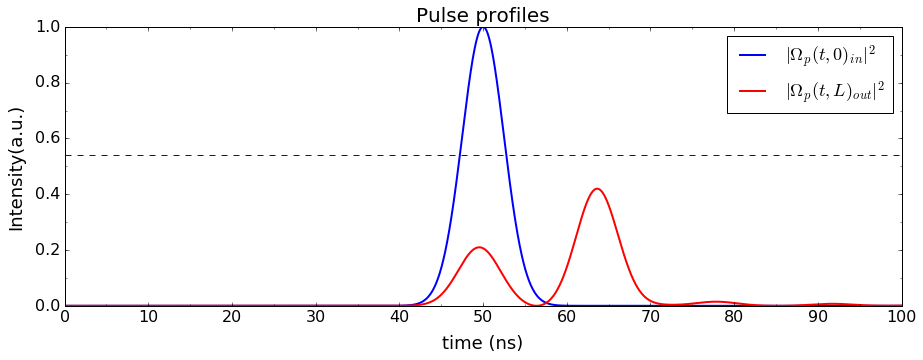

In [6]:
#Plot the input and output pulse
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(t, np.abs(OmegaP[:,0])**2, color='b', label=r"$|\Omega_p(t,0)_{in}|^{2}$", lw=2)
ax.plot(t, np.abs(OmegaP[:,-1])**2, color='r', label=r"$|\Omega_p(t,L)_{out}|^{2}$", lw=2)
ax.set_xlabel("time (ns)", fontsize=18, labelpad=10)
ax.set_ylabel("Intensity(a.u.)", fontsize=18, labelpad=10)
ax.set_title("Pulse profiles", fontsize=20)
ax.set_xlim(0,100)
ax.tick_params(labelsize=16)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.legend(fontsize=18)
ax.axhline(0.54, linestyle='--')

In [7]:
#Calculate the first echo efficiency
efficiency=(np.sum(np.abs(OmegaP[int(60/dt+1):int(80/dt+1),-1])**2*dt))/(np.sum(np.abs(OmegaP[int(35/dt+1):int(65/dt+1),0])**2*dt))
print(sympy.Float(efficiency, 4))

0.3998
